In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.manifold import TSNE
from qiskit.circuit.library import RealAmplitudes
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import math

## UTILS

In [64]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("CUDA Available:  ", torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {color.BOLD} {str(device).upper()} {color.END} Acceleration")

CUDA Available:   True
Using  CUDA  Acceleration


In [65]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# DATASET IMPORT

In [66]:
INITIAL_TRAINING_SAMPLES = 400


MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])


MNIST_dataset_train = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
MNIST_dataset_test = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)


if False:
    index01 = MNIST_dataset_train.train_labels <= 1
    MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
    MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

    index01_test = MNIST_dataset_test.train_labels <= 1
    MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
    MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]




print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=42,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")


'''
init_test_data, _, init_test_target, _ = train_test_split(
    range(len(MNIST_dataset_test)), 
    MNIST_dataset_test.targets,
    random_state=42,
    stratify=MNIST_dataset_test.targets,
    test_size=len(MNIST_dataset_test)- INITIAL_TESTING_SAMPLES)
'''

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")



FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (400, 28, 28)
Total training samples : 400

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



In [67]:
class MNIST_Distance_Dataset_Triplet_Loss(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.kers = np.ones((self.data.shape[0], self.data.shape[0]))
        self.output_transform = transforms.ToTensor()
        self.len = len(self.target)
        self.classes = {i:(np.where(self.target == i)[0], np.where(self.target != i)[0] ) for i in range(10)}


    def __getitem__(self, idx):
        return self.get_anchor(idx), self.get_positive(idx), self.get_negative(idx)
    
    def get_anchor(self, idx):
        return self.output_transform(self.data[idx])
    

    def get_positive(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][0])
        return self.output_transform(self.data[i])
    
    def get_negative(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][1])
        return self.output_transform(self.data[i])


    def get_order(self):
        return self.target.argsort()


    def ordered_pairwise(self):
        return self.kers[:,self.get_order()][self.get_order(),:]


    def get_flatten(self):
        return self.data.reshape((self.data.shape[0], self.data.shape[1]**2))


    def __len__(self):
        return self.len

300
100


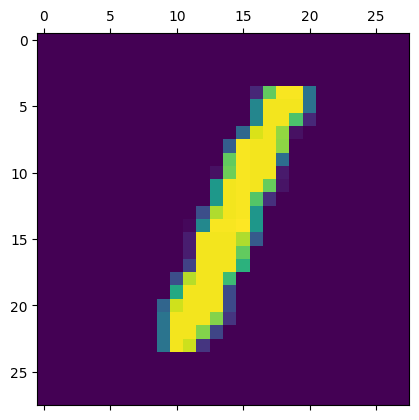

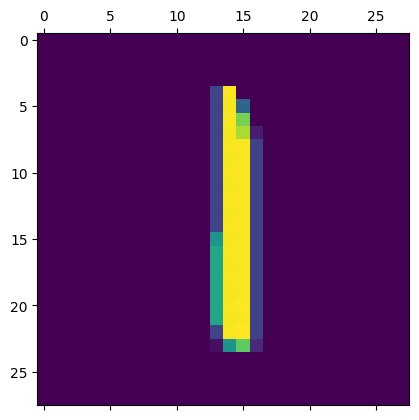

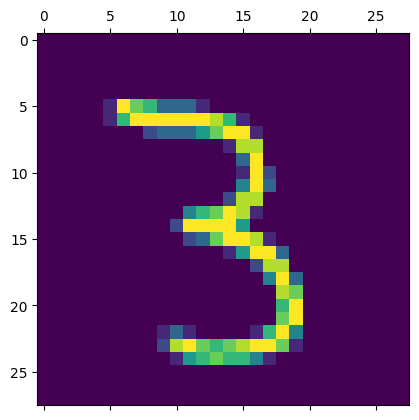

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
t = MNIST_Distance_Dataset_Triplet_Loss(X_train, y_train)
v = MNIST_Distance_Dataset_Triplet_Loss(X_val, y_val)
#stampa lunghezza del dataset

print(len(t))
print(len(v))

anchor, pos, neg = t[0]


plt.matshow(anchor.squeeze(0))
plt.matshow(pos.squeeze(0))
plt.matshow(neg.squeeze(0))



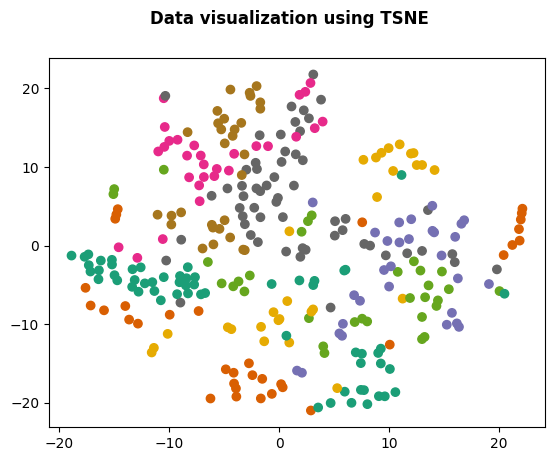

In [69]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# CIRCUITS


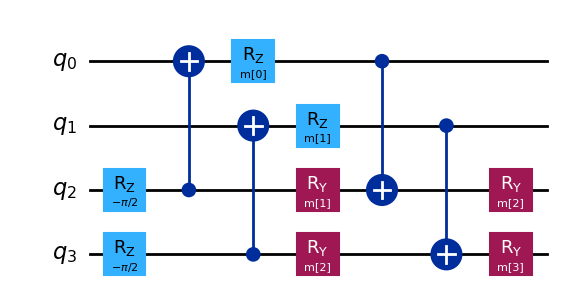

In [2]:
'''
Amplitude encoding, richiede nlog2 features
'''
def amplitude_encoding(n_features, param_name):
  qc = RawFeatureVector(n_features)
  qc = qc.assign_parameters(ParameterVector(param_name, n_features))
  qc.name = f"Amplitude Encoding {param_name}"
  return qc


def yz_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  n_qubit = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
  gates = [qc.ry, qc.rz]

  for i in range(n_qubit):
    for gate_i in range(2):
      pindex = i*2 + gate_i
      if pindex < n_features:
        gates[gate_i](params[pindex], i)

  return qc

def pooling_layer(in_lane, param_prefix="pool"):
  qc = QuantumCircuit(in_lane, name="Pooling Layer")
  params = ParameterVector(param_prefix, length=in_lane //2 *3)

  for i in range(in_lane//2):
    current = i
    aux = i+ in_lane//2

    base_param =  current*(in_lane//2 -1)

    qc.rz(-np.pi/2, aux)
    qc.cx(aux, current)
    qc.rz(params[base_param + 0], current)
    qc.ry(params[base_param + 1], aux)
    qc.cx(current, aux)
    qc.ry(params[base_param + 2], aux)

  return qc



pooling_layer(4, param_prefix="m").draw(output="mpl")

# MODIFICHE ENCODING


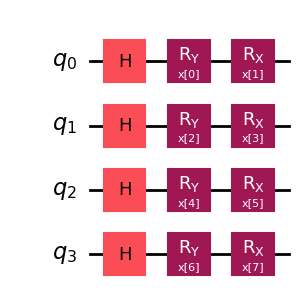

In [3]:
#Modifiche PROF
def hRyRx_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2

  return feature_map

hRyRx_encoding(8).draw(output="mpl")


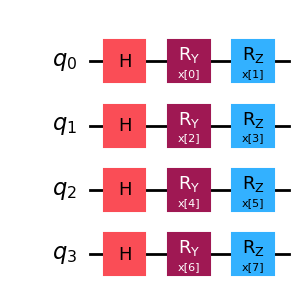

In [4]:
def hRyRz_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rz(input_params[idx+1], i)
      idx +=2
  return feature_map

hRyRz_encoding(8).draw(output="mpl")

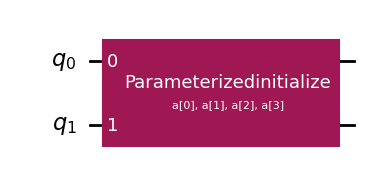

In [32]:
amplitude_encoding(4, "a").draw(output="mpl")

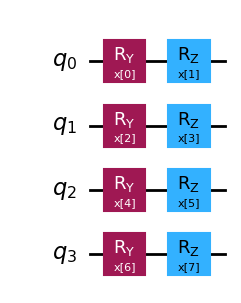

In [33]:
yz_angles_encoding(8, param_name="x").draw(output="mpl")

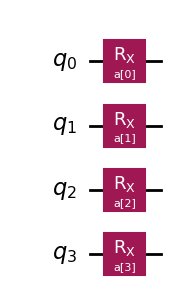

In [5]:
def x_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  n_qubit = n_features
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
  

  for i in range(n_qubit):
    qc.rx(params[i], i)

  return qc

x_angles_encoding(4, "a").draw(output="mpl")

# Encoding RyRx


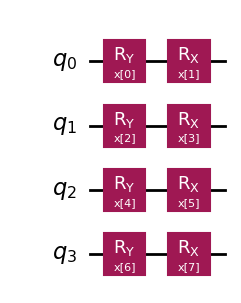

In [6]:
def RyRx_encoding(n_features): 
# qubits
   n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
   # feature extracted from neural network
   n_feature = n_features
   feature_map = QuantumCircuit(n_qubits)
   input_params = ParameterVector(name='x', length=n_feature)
   idx = 0
   for i in range(n_qubits):
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2
   return feature_map

RyRx_encoding(8).draw(output="mpl")

# TENSOR NETWORK

# MPS


In [7]:
def MPS(num_qubits,parameter_prefix="x", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = RealAmplitudes(2, parameter_prefix=f"{parameter_prefix}_{i},{j}", **kwargs)
        qc.compose(block, [i, j], inplace=True)
        qc.barrier()
    return qc



# TTN

In [8]:
def _generate_tree_tuples(n):
    """
    Generate a list of tuples representing the tree structure 
    of consecutive numbers up to n.

    Args:
        n (int): The number up to which the tuples are generated.

    Returns:
        list: A list of tuples representing the tree structure.
    """
    tuples_list = []
    indices = []

    # Generate initial tuples with consecutive numbers up to n
    for i in range(0, n, 2):
        tuples_list.append((i, i + 1))

    indices += [tuples_list]

    # Perform iterations until we reach a single tuple
    while len(tuples_list) > 1:
        new_tuples = []

        # Generate new tuples by combining adjacent larger numbers
        for i in range(0, len(tuples_list), 2):
            new_tuples.append((tuples_list[i][1], tuples_list[i + 1][1]))

        tuples_list = new_tuples
        indices += [tuples_list]

    return indices

In [9]:
def TTN(num_qubits, parameter_prefix="θ", **kwargs):
    """
    Constructs a Tree Tensor Network (TTN) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed TTN quantum circuit.

    Raises:
        AssertionError: If the number of qubits is not a power of 2 
        or zero.
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)

     # Compute qubit indices
    assert num_qubits & (
        num_qubits -
        1) == 0 and num_qubits != 0, "Number of qubits must be a power of 2"

    # Genera gli indici gerarchici della TTN
    indices = _generate_tree_tuples(num_qubits)

    # Aggiungi blocchi RealAmplitudes in struttura ad albero
    for layer_indices in indices:
        for i, j in layer_indices:
            block = RealAmplitudes(
                num_qubits=2,
                parameter_prefix=f"{parameter_prefix}_{i},{j}",  # Usa il prefisso
                **kwargs
            )
            qc.compose(block, [i, j], inplace=True)
        qc.barrier()

    return qc

# CMPS E CTTN

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import Parameter


def CMPS(n):
    qubits = list(range(n))
    ansatz = QuantumCircuit(n)

    idx = 0

    qubit_coupled = list(zip(qubits[::1], qubits[1::]))
    for q_1, q_2 in qubit_coupled:
        ansatz.rx(Parameter(f'θ[{idx}]'), q_1)
        idx += 1
        ansatz.ry(Parameter(f'θ[{idx}]'), q_2)
        idx += 1
        ansatz.cx(q_1, q_2)

    return ansatz

def CTTN(n):
    ansatz = QuantumCircuit(n)

    idx = 0
    layer = _generate_tree_tuples(n)

    for qubits_coupled in layer:
        for q_1, q_2 in qubits_coupled:
            ansatz.rx(Parameter(f'θ[{idx}]'), q_1)
            idx += 1
            ansatz.rx(Parameter(f'θ[{idx}]'), q_2)
            idx += 1
            ansatz.cx(q_1, q_2)
    return ansatz

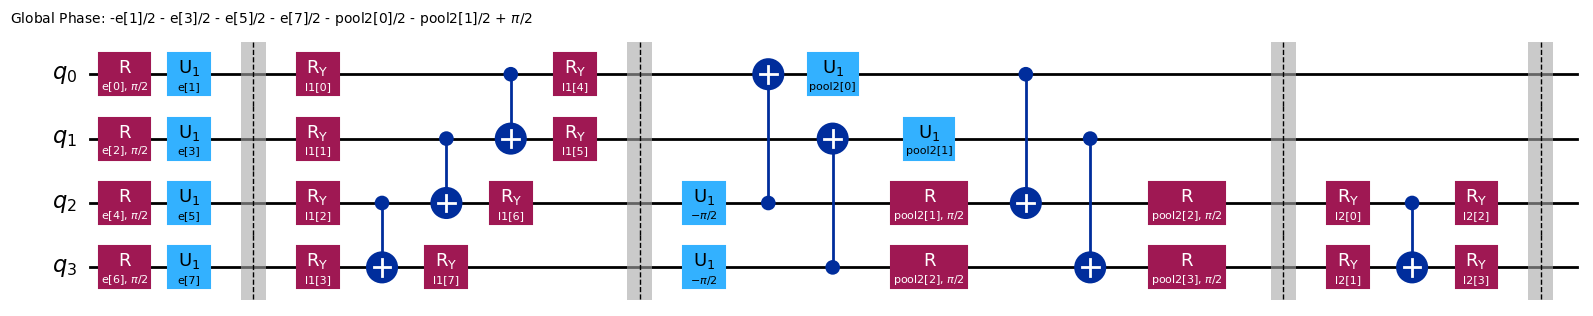

In [47]:
encoding = yz_angles_encoding(8, param_name="e")
#encoding = hRyRx_encoding(8)
#encoding= hRyRz_encoding(8)
#encoding = RyRx_encoding(8)



#pooling = pooling_layer(4, "pool1")

ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################3#######################
ansatz = ansatz.compose(pooling_layer(4, "pool2"))
ansatz.barrier()
############################4#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer2",parameter_prefix="l2"), qubits=[2,3])
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))



# CIRCUITO CON TN (TTN + MPS)

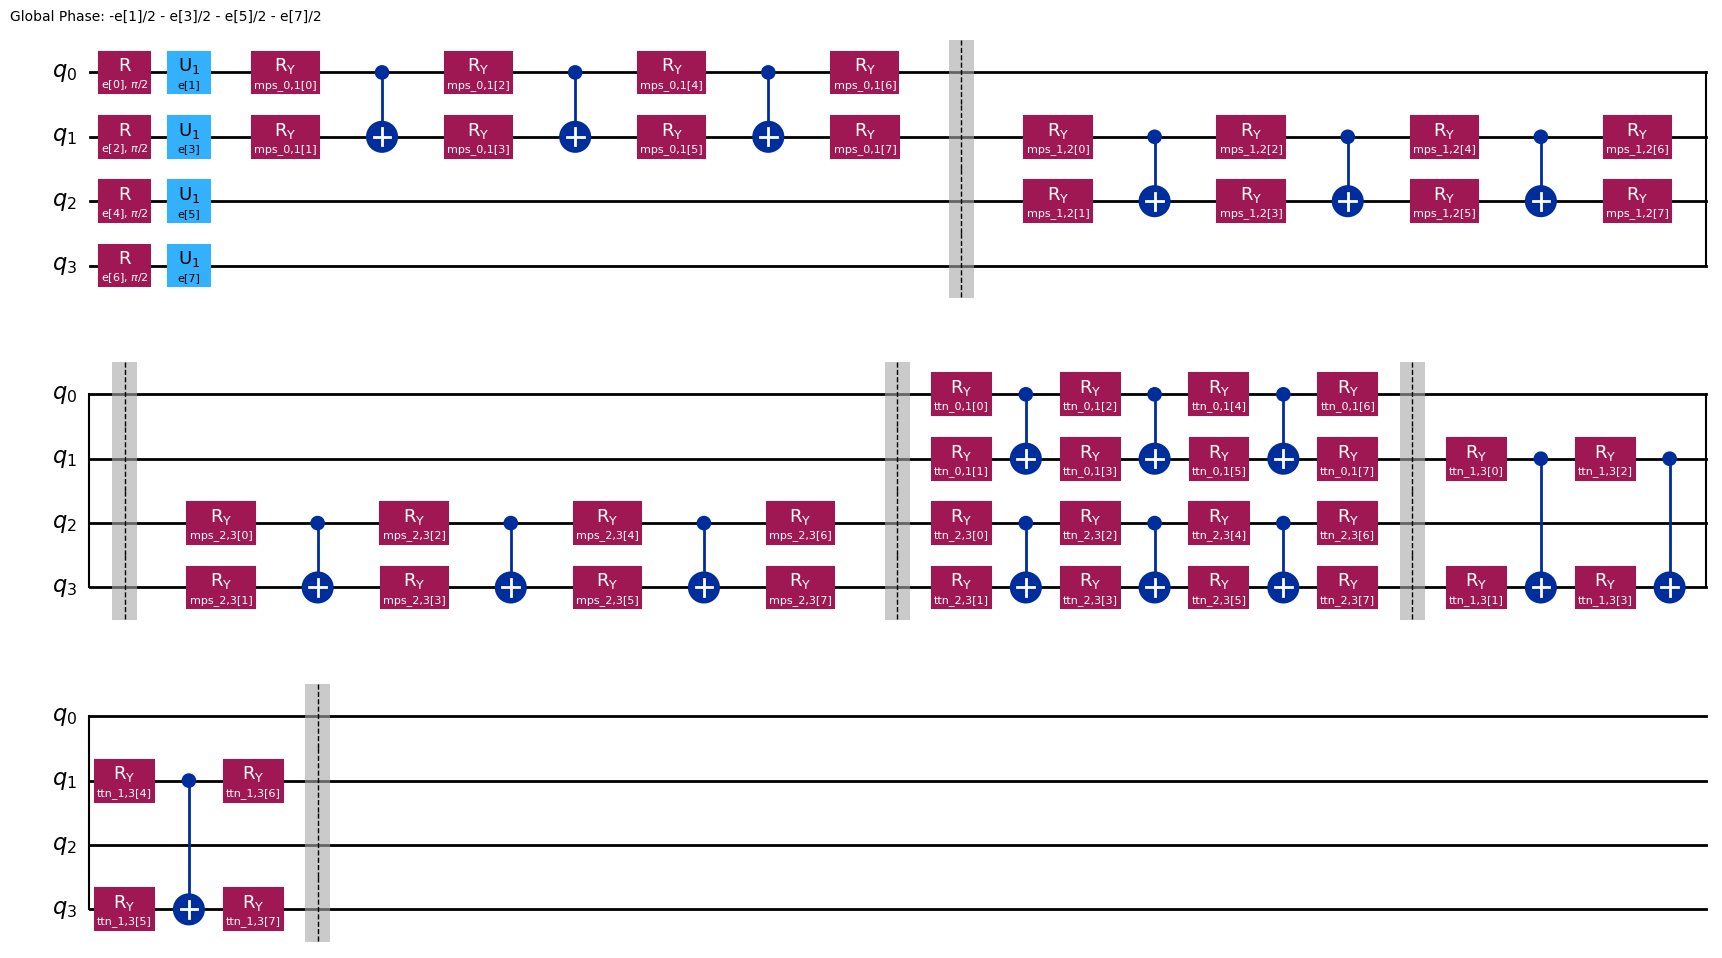

In [ ]:
encoding = yz_angles_encoding(8, param_name="e")

# Creazione del circuito di encoding
ansatz = QuantumCircuit(4)
ansatz.barrier()

# Aggiunta di MPS
ansatz= ansatz.compose(MPS(num_qubits=4, parameter_prefix="mps"))


# Aggiunta di TTN
ansatz= ansatz.compose(TTN(num_qubits=4, parameter_prefix="ttn"))

qnn= QuantumCircuit(4).compose(encoding).compose(ansatz)



# Visualizzazione del circuito
display(qnn.decompose().draw("text"))


# CIRCUITO CON TN ( solo MPS)

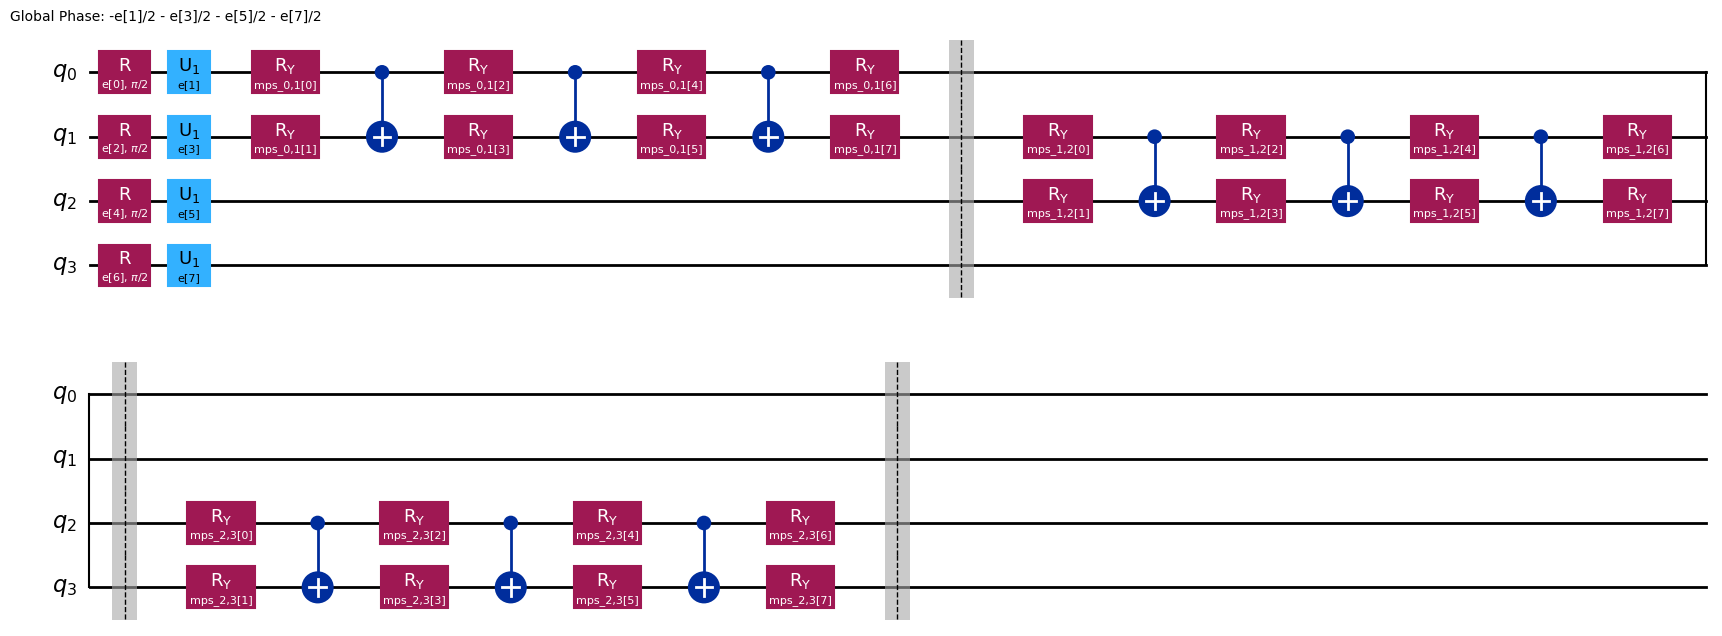

In [75]:
encoding = yz_angles_encoding(8, param_name="e")


qnn = QuantumCircuit(4).compose(encoding)

# Aggiunta dell'MPS al circuito
mps_ansatz = MPS(num_qubits=4, parameter_prefix="mps")
qnn = qnn.compose(mps_ansatz)

# Visualizzazione del circuito
display(qnn.decompose().draw("mpl"))






# CIRCUITO CON TN  (CMPS)

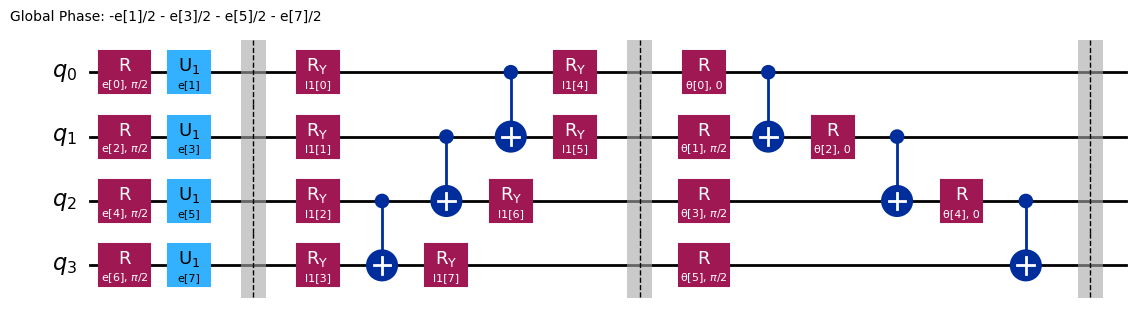

In [49]:

encoding = yz_angles_encoding(8, param_name="e")

ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################CMPS#######################
ansatz= ansatz.compose(CMPS(4))
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))



# CIRCUITO CON TN (CTTN)

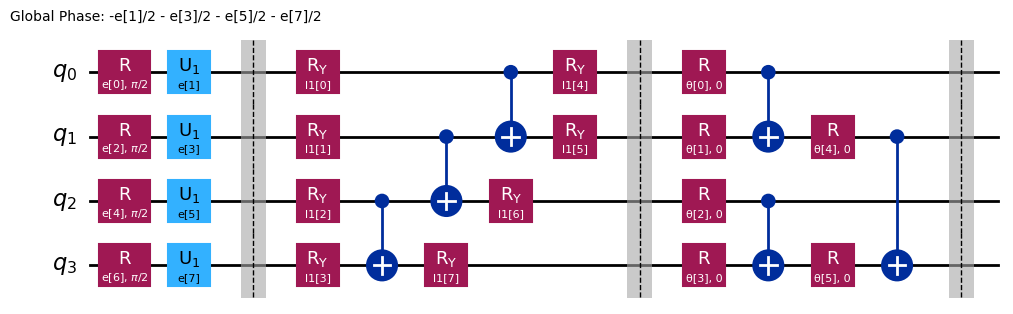

In [50]:
encoding = yz_angles_encoding(8, param_name="e")

ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################CTTN#######################
ansatz= ansatz.compose(CTTN(4))
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))

In [76]:
# Prima di creare il SamplerQNN
print("Numero di parametri nel circuito:", len(qnn.parameters))
print("Parameters encoding:", encoding.parameters)
print("Parameters ansatz:", ansatz.parameters)



Numero di parametri nel circuito: 32
Parameters encoding: ParameterView([ParameterVectorElement(e[0]), ParameterVectorElement(e[1]), ParameterVectorElement(e[2]), ParameterVectorElement(e[3]), ParameterVectorElement(e[4]), ParameterVectorElement(e[5]), ParameterVectorElement(e[6]), ParameterVectorElement(e[7])])
Parameters ansatz: ParameterView([ParameterVectorElement(l1[0]), ParameterVectorElement(l1[1]), ParameterVectorElement(l1[2]), ParameterVectorElement(l1[3]), ParameterVectorElement(l1[4]), ParameterVectorElement(l1[5]), ParameterVectorElement(l1[6]), ParameterVectorElement(l1[7]), Parameter(θ[0]), Parameter(θ[1]), Parameter(θ[2]), Parameter(θ[3]), Parameter(θ[4]), Parameter(θ[5])])


In [77]:
print("Encoding parameters:", len(encoding.parameters))
print("Ansatz parameters:", len(mps_ansatz.parameters))
print("Total parameters in circuit:", len(qnn.parameters))
print("Number of parameters in MPS ansatz:", len(mps_ansatz.parameters))

Encoding parameters: 8
Ansatz parameters: 24
Total parameters in circuit: 32
Number of parameters in MPS ansatz: 24


In [78]:
from qiskit.primitives import Sampler
def parity(x):
    return f"{bin(x)}".count("1")



qmodel_1 = SamplerQNN(
    circuit=qnn,
    input_params=encoding.parameters,
    weight_params=mps_ansatz.parameters,
    input_gradients=True
    
)




class HybridRegressorConvNet(nn.Module):
    def __init__(self, qm1):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=8)
        )
     
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),

        )

        self.q1 = TorchConnector(qm1)


    
    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)

        x = self.reduction(x)

        #Per encoding con HRyRz
        x = x * (math.pi / 2)
        #x= self.q1(x)
        
        x = self.q1(x) * 100

        x = self.final(x)

        return x
    

distance_model = HybridRegressorConvNet(qmodel_1)
distance_model = distance_model.to("cuda")
summary(distance_model, input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 8]             968
   TorchConnector-13                   [-1, 16]              24
           Linear-14                   

C:\Users\Utente\AppData\Local\Temp\ipykernel_4884\3539319404.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qmodel_1 = SamplerQNN(


# TRAIN

In [102]:
distance_model = HybridRegressorConvNet(qmodel_1)
training_dataloader = DataLoader(t, batch_size=10, shuffle=True)
val_data_loader = DataLoader(v, batch_size=10, shuffle=True)
distance_model = distance_model.to(torch.device("cuda"))
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = torch.nn.TripletMarginLoss(margin=2)
epochs = 100


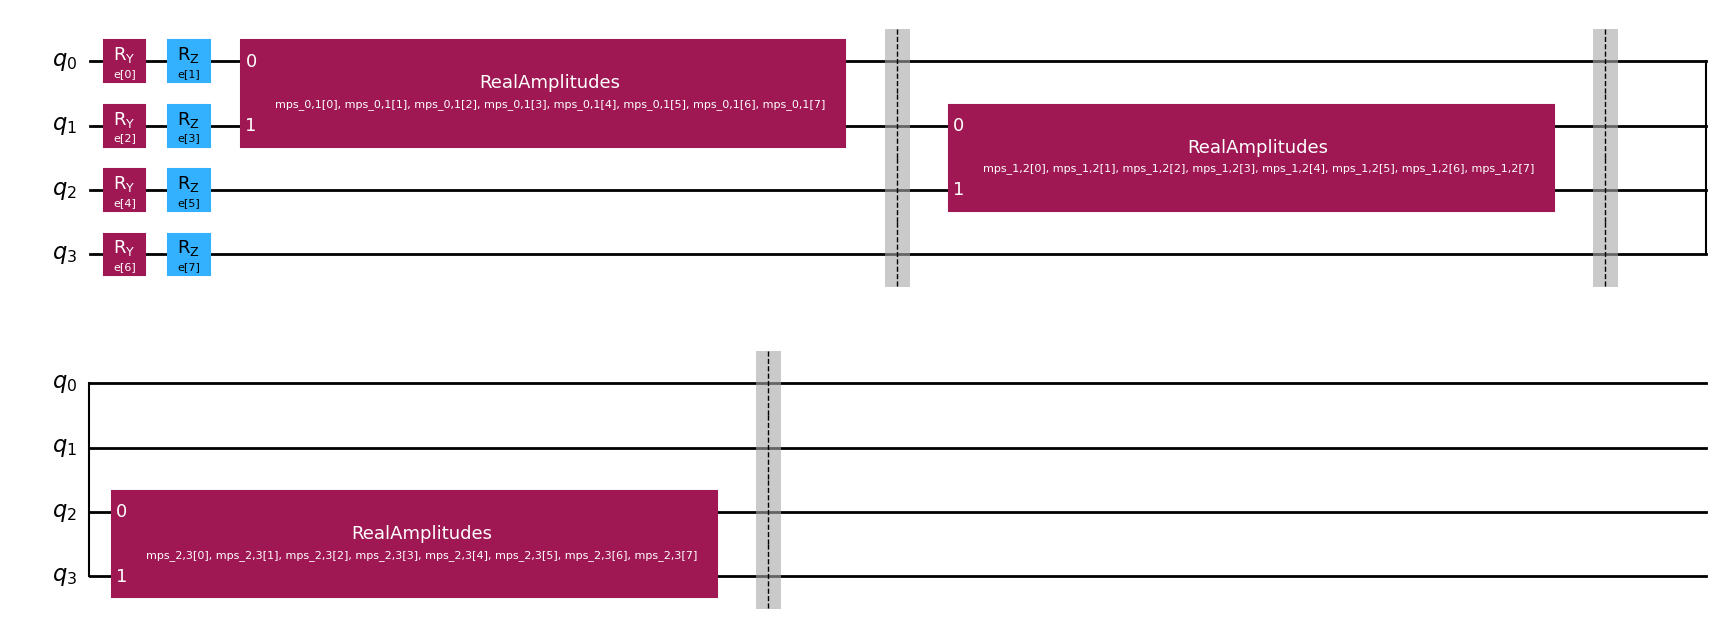

In [98]:
qmodel_1.circuit.draw(output="mpl")

In [130]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1):

        
    for epoch in range(epochs):

        prnt = (epoch % print_at) != 0 if epoch!=(epochs-1) else False


        if not(prnt):
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase

        model.train()

        train_loss = 0.0
        train_samples = 0

        

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()


            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)


            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)


            

            loss = criterion(e_A, e_P, e_N)

            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_samples += positive.size(0)


        train_loss /= len(train_data_loader)
        
        if not(prnt):
            print(f"TRAINING   -> Loss: {train_loss:2.6f}")
            print("")    

# TRAIN WITH EARLY STOPPING


In [99]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, 
          validation_step=False, print_at=1, early_stopping_patience=3, 
          min_delta=0.001, restore_best_weights=True):
    
    best_loss = float('inf')
    no_improvement_count = 0
    best_model_state = None

    for epoch in range(epochs):
        prnt = (epoch % print_at) != 0 if epoch != (epochs-1) else False

        # Inizializza early_stopping_triggered all'inizio di ogni epoch
        early_stopping_triggered = False

        if not prnt:
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)

            loss = criterion(e_A, e_P, e_N)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_samples += positive.size(0)

        train_loss /= len(train_data_loader)
        
        ### --> Validation Phase (solo se richiesto)
        val_loss = 0.0
        if validation_step and not prnt:
            model.eval()
            with torch.no_grad():
                for anchor, positive, negative in val_data_loader:
                    anchor = anchor.to(device)
                    positive = positive.to(device)
                    negative = negative.to(device)

                    e_A = model(anchor)
                    e_P = model(positive)
                    e_N = model(negative)

                    loss = criterion(e_A, e_P, e_N)
                    val_loss += loss.item()

                val_loss /= len(val_data_loader)

        ### --> Early Stopping Logic
        if validation_step and not prnt:
            # Controlla miglioramento
            if (best_loss - val_loss) > min_delta:
                best_epoch = epoch
                best_loss = val_loss
                no_improvement_count = 0
                # Salva lo stato del modello migliore
                if restore_best_weights:
                    print("Best epoch: ", best_epoch)
                    best_model_state = model.state_dict().copy()
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print(f"\n{color.RED}Early stopping at epoch {epoch+1}{color.END}")
                    early_stopping_triggered = True

        ### --> Stampa risultati
        if not prnt:
            log_str = f"TRAINING   -> Loss: {train_loss:2.6f}"
            if validation_step:
                log_str += f" | VALIDATION -> Loss: {val_loss:2.6f}"
            print(log_str)
            print("")

        ### --> Interrompi il training se early stopping
        if early_stopping_triggered:
            break

    ### --> Ripristina i migliori pesi se richiesto
    if restore_best_weights and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{color.GREEN}Restored best model weights{color.END}")

    return model

In [103]:
'''
train(
    model=distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=torch.device("cuda"),
    print_at=1
)
'''

distance_model = train(
    distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=val_data_loader,
    device=device,
    validation_step=True,
    early_stopping_patience=50,
    min_delta=0.005
)


Epoch 1


100%|██████████| 30/30 [02:02<00:00,  4.08s/it]


Best epoch:  0
TRAINING   -> Loss: 1.540906 | VALIDATION -> Loss: 1.167831

Epoch 2


100%|██████████| 30/30 [02:00<00:00,  4.03s/it]


Best epoch:  1
TRAINING   -> Loss: 0.973136 | VALIDATION -> Loss: 0.814639

Epoch 3


100%|██████████| 30/30 [02:02<00:00,  4.09s/it]


Best epoch:  2
TRAINING   -> Loss: 0.861903 | VALIDATION -> Loss: 0.696507

Epoch 4


100%|██████████| 30/30 [02:02<00:00,  4.09s/it]


TRAINING   -> Loss: 0.799511 | VALIDATION -> Loss: 0.832467

Epoch 5


100%|██████████| 30/30 [04:39<00:00,  9.33s/it]


TRAINING   -> Loss: 0.759498 | VALIDATION -> Loss: 0.696396

Epoch 6


100%|██████████| 30/30 [03:46<00:00,  7.53s/it]


TRAINING   -> Loss: 0.621040 | VALIDATION -> Loss: 0.768807

Epoch 7


100%|██████████| 30/30 [02:06<00:00,  4.21s/it]


TRAINING   -> Loss: 0.509009 | VALIDATION -> Loss: 0.720983

Epoch 8


100%|██████████| 30/30 [02:05<00:00,  4.19s/it]


TRAINING   -> Loss: 0.434155 | VALIDATION -> Loss: 0.901741

Epoch 9


100%|██████████| 30/30 [02:19<00:00,  4.63s/it]


TRAINING   -> Loss: 0.477459 | VALIDATION -> Loss: 0.910835

Epoch 10


100%|██████████| 30/30 [03:29<00:00,  6.97s/it]


TRAINING   -> Loss: 0.500619 | VALIDATION -> Loss: 1.004089

Epoch 11


100%|██████████| 30/30 [03:00<00:00,  6.03s/it]


TRAINING   -> Loss: 0.392467 | VALIDATION -> Loss: 0.762174

Epoch 12


100%|██████████| 30/30 [05:55<00:00, 11.85s/it]


Best epoch:  11
TRAINING   -> Loss: 0.403746 | VALIDATION -> Loss: 0.433819

Epoch 13


100%|██████████| 30/30 [06:37<00:00, 13.25s/it]


TRAINING   -> Loss: 0.384760 | VALIDATION -> Loss: 0.563385

Epoch 14


100%|██████████| 30/30 [02:17<00:00,  4.60s/it]


Best epoch:  13
TRAINING   -> Loss: 0.265711 | VALIDATION -> Loss: 0.427135

Epoch 15


100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


TRAINING   -> Loss: 0.180955 | VALIDATION -> Loss: 0.456639

Epoch 16


100%|██████████| 30/30 [02:04<00:00,  4.14s/it]


TRAINING   -> Loss: 0.316613 | VALIDATION -> Loss: 0.465629

Epoch 17


100%|██████████| 30/30 [06:12<00:00, 12.40s/it]


TRAINING   -> Loss: 0.206926 | VALIDATION -> Loss: 0.665807

Epoch 18


100%|██████████| 30/30 [05:54<00:00, 11.83s/it]


TRAINING   -> Loss: 0.205676 | VALIDATION -> Loss: 0.655943

Epoch 19


100%|██████████| 30/30 [04:11<00:00,  8.39s/it]


TRAINING   -> Loss: 0.122961 | VALIDATION -> Loss: 0.760728

Epoch 20


100%|██████████| 30/30 [02:23<00:00,  4.78s/it]


TRAINING   -> Loss: 0.055992 | VALIDATION -> Loss: 0.599097

Epoch 21


100%|██████████| 30/30 [02:28<00:00,  4.94s/it]


TRAINING   -> Loss: 0.164365 | VALIDATION -> Loss: 0.727872

Epoch 22


100%|██████████| 30/30 [02:27<00:00,  4.92s/it]


TRAINING   -> Loss: 0.134971 | VALIDATION -> Loss: 0.941405

Epoch 23


100%|██████████| 30/30 [02:40<00:00,  5.35s/it]


TRAINING   -> Loss: 0.151225 | VALIDATION -> Loss: 0.533908

Epoch 24


100%|██████████| 30/30 [05:02<00:00, 10.10s/it]


TRAINING   -> Loss: 0.079999 | VALIDATION -> Loss: 0.744344

Epoch 25


100%|██████████| 30/30 [04:58<00:00,  9.96s/it]


TRAINING   -> Loss: 0.084141 | VALIDATION -> Loss: 0.699685

Epoch 26


100%|██████████| 30/30 [05:00<00:00, 10.03s/it]


TRAINING   -> Loss: 0.091287 | VALIDATION -> Loss: 0.469558

Epoch 27


100%|██████████| 30/30 [04:50<00:00,  9.67s/it]


TRAINING   -> Loss: 0.072642 | VALIDATION -> Loss: 0.544337

Epoch 28


100%|██████████| 30/30 [04:41<00:00,  9.39s/it]


Best epoch:  27
TRAINING   -> Loss: 0.070005 | VALIDATION -> Loss: 0.336186

Epoch 29


100%|██████████| 30/30 [04:39<00:00,  9.31s/it]


TRAINING   -> Loss: 0.049815 | VALIDATION -> Loss: 0.447826

Epoch 30


100%|██████████| 30/30 [04:31<00:00,  9.03s/it]


Best epoch:  29
TRAINING   -> Loss: 0.007366 | VALIDATION -> Loss: 0.182180

Epoch 31


100%|██████████| 30/30 [04:24<00:00,  8.80s/it]


TRAINING   -> Loss: 0.035507 | VALIDATION -> Loss: 0.378323

Epoch 32


100%|██████████| 30/30 [01:51<00:00,  3.72s/it]


TRAINING   -> Loss: 0.013770 | VALIDATION -> Loss: 0.619941

Epoch 33


100%|██████████| 30/30 [01:51<00:00,  3.72s/it]


TRAINING   -> Loss: 0.047521 | VALIDATION -> Loss: 0.656333

Epoch 34


100%|██████████| 30/30 [02:49<00:00,  5.65s/it]


TRAINING   -> Loss: 0.047591 | VALIDATION -> Loss: 0.455087

Epoch 35


100%|██████████| 30/30 [06:29<00:00, 12.98s/it]


TRAINING   -> Loss: 0.065830 | VALIDATION -> Loss: 0.649556

Epoch 36


100%|██████████| 30/30 [06:39<00:00, 13.31s/it]


TRAINING   -> Loss: 0.064374 | VALIDATION -> Loss: 0.275732

Epoch 37


100%|██████████| 30/30 [06:37<00:00, 13.26s/it]


TRAINING   -> Loss: 0.093947 | VALIDATION -> Loss: 0.782593

Epoch 38


100%|██████████| 30/30 [06:37<00:00, 13.26s/it]


TRAINING   -> Loss: 0.049589 | VALIDATION -> Loss: 0.619926

Epoch 39


100%|██████████| 30/30 [06:58<00:00, 13.96s/it]


TRAINING   -> Loss: 0.052967 | VALIDATION -> Loss: 0.648498

Epoch 40


100%|██████████| 30/30 [07:27<00:00, 14.93s/it]


TRAINING   -> Loss: 0.044298 | VALIDATION -> Loss: 0.432495

Epoch 41


100%|██████████| 30/30 [07:44<00:00, 15.49s/it]


TRAINING   -> Loss: 0.035922 | VALIDATION -> Loss: 0.627086

Epoch 42


100%|██████████| 30/30 [07:14<00:00, 14.49s/it]


TRAINING   -> Loss: 0.026796 | VALIDATION -> Loss: 0.615707

Epoch 43


100%|██████████| 30/30 [06:43<00:00, 13.46s/it]


TRAINING   -> Loss: 0.082133 | VALIDATION -> Loss: 0.435210

Epoch 44


100%|██████████| 30/30 [01:09<00:00,  2.33s/it]


TRAINING   -> Loss: 0.009921 | VALIDATION -> Loss: 0.277092

Epoch 45


100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


TRAINING   -> Loss: 0.021739 | VALIDATION -> Loss: 0.538755

Epoch 46


100%|██████████| 30/30 [03:04<00:00,  6.16s/it]


TRAINING   -> Loss: 0.014328 | VALIDATION -> Loss: 0.511361

Epoch 47


100%|██████████| 30/30 [03:41<00:00,  7.39s/it]


TRAINING   -> Loss: 0.010254 | VALIDATION -> Loss: 0.472895

Epoch 48


100%|██████████| 30/30 [03:00<00:00,  6.03s/it]


TRAINING   -> Loss: 0.044779 | VALIDATION -> Loss: 0.500629

Epoch 49


100%|██████████| 30/30 [02:18<00:00,  4.61s/it]


TRAINING   -> Loss: 0.020968 | VALIDATION -> Loss: 0.533981

Epoch 50


100%|██████████| 30/30 [02:01<00:00,  4.03s/it]


TRAINING   -> Loss: 0.042141 | VALIDATION -> Loss: 0.697168

Epoch 51


100%|██████████| 30/30 [02:18<00:00,  4.61s/it]


TRAINING   -> Loss: 0.004860 | VALIDATION -> Loss: 0.521890

Epoch 52


100%|██████████| 30/30 [02:16<00:00,  4.54s/it]


TRAINING   -> Loss: 0.078595 | VALIDATION -> Loss: 0.649725

Epoch 53


100%|██████████| 30/30 [02:22<00:00,  4.75s/it]


TRAINING   -> Loss: 0.054169 | VALIDATION -> Loss: 0.812064

Epoch 54


100%|██████████| 30/30 [02:23<00:00,  4.79s/it]


TRAINING   -> Loss: 0.026377 | VALIDATION -> Loss: 0.728722

Epoch 55


100%|██████████| 30/30 [02:22<00:00,  4.75s/it]


TRAINING   -> Loss: 0.014622 | VALIDATION -> Loss: 0.718350

Epoch 56


100%|██████████| 30/30 [02:22<00:00,  4.74s/it]


TRAINING   -> Loss: 0.048133 | VALIDATION -> Loss: 0.700942

Epoch 57


100%|██████████| 30/30 [02:18<00:00,  4.63s/it]


TRAINING   -> Loss: 0.032881 | VALIDATION -> Loss: 0.611835

Epoch 58


100%|██████████| 30/30 [02:14<00:00,  4.48s/it]


TRAINING   -> Loss: 0.028085 | VALIDATION -> Loss: 0.724174

Epoch 59


100%|██████████| 30/30 [02:16<00:00,  4.54s/it]


TRAINING   -> Loss: 0.040534 | VALIDATION -> Loss: 0.667979

Epoch 60


100%|██████████| 30/30 [02:16<00:00,  4.54s/it]


TRAINING   -> Loss: 0.020028 | VALIDATION -> Loss: 0.670531

Epoch 61


100%|██████████| 30/30 [02:16<00:00,  4.55s/it]


TRAINING   -> Loss: 0.026141 | VALIDATION -> Loss: 0.281016

Epoch 62


100%|██████████| 30/30 [02:12<00:00,  4.42s/it]


TRAINING   -> Loss: 0.010302 | VALIDATION -> Loss: 0.501157

Epoch 63


100%|██████████| 30/30 [02:25<00:00,  4.84s/it]


TRAINING   -> Loss: 0.047591 | VALIDATION -> Loss: 0.646282

Epoch 64


100%|██████████| 30/30 [01:40<00:00,  3.34s/it]


TRAINING   -> Loss: 0.030522 | VALIDATION -> Loss: 0.418151

Epoch 65


100%|██████████| 30/30 [01:09<00:00,  2.32s/it]


TRAINING   -> Loss: 0.024157 | VALIDATION -> Loss: 0.565077

Epoch 66


100%|██████████| 30/30 [02:03<00:00,  4.13s/it]


TRAINING   -> Loss: 0.076666 | VALIDATION -> Loss: 0.799719

Epoch 67


100%|██████████| 30/30 [03:26<00:00,  6.89s/it]


TRAINING   -> Loss: 0.037438 | VALIDATION -> Loss: 0.640634

Epoch 68


100%|██████████| 30/30 [03:30<00:00,  7.02s/it]


TRAINING   -> Loss: 0.011024 | VALIDATION -> Loss: 0.371211

Epoch 69


100%|██████████| 30/30 [03:17<00:00,  6.58s/it]


TRAINING   -> Loss: 0.022244 | VALIDATION -> Loss: 0.345963

Epoch 70


100%|██████████| 30/30 [02:35<00:00,  5.18s/it]


TRAINING   -> Loss: 0.002353 | VALIDATION -> Loss: 0.329464

Epoch 71


100%|██████████| 30/30 [02:14<00:00,  4.49s/it]


TRAINING   -> Loss: 0.028201 | VALIDATION -> Loss: 0.450737

Epoch 72


100%|██████████| 30/30 [02:13<00:00,  4.46s/it]


TRAINING   -> Loss: 0.001798 | VALIDATION -> Loss: 0.465640

Epoch 73


100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


TRAINING   -> Loss: 0.005995 | VALIDATION -> Loss: 0.412311

Epoch 74


100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


TRAINING   -> Loss: 0.022829 | VALIDATION -> Loss: 0.599368

Epoch 75


100%|██████████| 30/30 [01:09<00:00,  2.32s/it]


TRAINING   -> Loss: 0.004620 | VALIDATION -> Loss: 0.308057

Epoch 76


100%|██████████| 30/30 [02:05<00:00,  4.17s/it]


TRAINING   -> Loss: 0.032483 | VALIDATION -> Loss: 0.489820

Epoch 77


100%|██████████| 30/30 [03:37<00:00,  7.25s/it]


TRAINING   -> Loss: 0.000000 | VALIDATION -> Loss: 0.363737

Epoch 78


100%|██████████| 30/30 [03:42<00:00,  7.43s/it]


TRAINING   -> Loss: 0.000705 | VALIDATION -> Loss: 0.602454

Epoch 79


100%|██████████| 30/30 [03:47<00:00,  7.57s/it]


TRAINING   -> Loss: 0.017820 | VALIDATION -> Loss: 0.508246

Epoch 80


100%|██████████| 30/30 [03:47<00:00,  7.57s/it]



Early stopping at epoch 80
TRAINING   -> Loss: 0.003121 | VALIDATION -> Loss: 0.314649

Restored best model weights


In [83]:
#save the model
with open(r"C:\Users\Utente\Desktop\quantum_metric_learning-master\models\triplet_loss\QuantumTripletLossMNIST_MPS.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

In [84]:

#with open(r"c:\Users\Utente\Desktop\quantum_metric_learning-master\models\triplet_loss\QuantumTripletLossMNIST.pt", "rb") as f:
#    distance_model.load_state_dict(torch.load(f))

with open(r"C:\Users\Utente\Desktop\quantum_metric_learning-master\models\triplet_loss\QuantumTripletLossMNIST_MPS.pt", "rb") as f:
    distance_model.load_state_dict(torch.load(f))
distance_model

C:\Users\Utente\AppData\Local\Temp\ipykernel_4884\3901872958.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distance_model.load_state_dict(torch.load(f))


HybridRegressorConvNet(
  (conv_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (reduction): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=8, bias=True)
  )
  (final): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (q1): TorchConnector()
)

# EVALUATION

In [85]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(training_dataloader):
        anchor = anchor.to(device)
        embedding_data = np.concatenate((embedding_data,distance_model(anchor).to("cpu").squeeze(0).numpy()), axis=0)


100%|██████████| 30/30 [00:02<00:00, 13.76it/s]


In [86]:
#confronto tra la distanza dei dati originali e la distanza dei dati embending ottenuiti tramite il modello ibrido
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

In [87]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.353
Purity:        0.610


In [88]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.387
Purity:        0.683


In [89]:

training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    clustering_data = np.empty((0,8))
    for anchor, _,_ in tqdm(training_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data,x.to("cpu").squeeze(0).numpy()), axis=0)

clustering_data.shape

100%|██████████| 30/30 [00:00<00:00, 264.77it/s]


(300, 8)

In [90]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

#quantum_w è un insieme di pesi ottenuti da distance_model.q1. Viene trasformato in un array NumPy e usato nei parametri del circuito.
#qemb_circuit è il circuito quantistico associato alla rete neurale quantistica.
quantum_w = distance_model.q1.weight.detach().to("cpu").numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

def quantum_embedding_distance(x,y):
    '''
    base: Un registro quantistico di 8 qubit per rappresentare i dati.
    ancilla: Un singolo qubit ausiliario necessario per lo SWAP test.
    classical: Un registro classico per immagazzinare il risultato della misura.
    swap_circuit: Il circuito quantistico che eseguirà il test.
    '''
    base = QuantumRegister(8, "data")
    ancilla = QuantumRegister(1, 'ancilla')
    classical = ClassicalRegister(1, 'output')
    swap_circuit = QuantumCircuit(base, ancilla, classical)

    '''
    w1 e w2 sono le versioni estese dei vettori x e y, a cui vengono aggiunti i pesi quantum_w.
    q1 e q2 sono i circuiti parametrizzati con w1 e w2, che rappresentano gli stati quantistici degli embedding.
    '''
    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    '''
    q1 viene caricato nei primi 4 qubit del registro base.
    q2 viene caricato nei secondi 4 qubit del registro base.
    A questo punto, il circuito ha due stati quantistici distinti |ψ1⟩ e |ψ2⟩ caricati nei primi 4 e ultimi 4 qubit.
    '''
    swap_circuit = swap_circuit.compose(q1, [0,1,2,3])
    swap_circuit = swap_circuit.compose(q2, [4,5,6,7])

    # Implementazione dello SWAP test, serve per misurare la somiglianza tra i due stati quantistici |ψ1⟩ e |ψ2⟩.
    swap_circuit.barrier()

    swap_circuit.h(ancilla)
    swap_circuit.cswap(ancilla, 0,4)
    swap_circuit.cswap(ancilla, 1,5)
    swap_circuit.cswap(ancilla, 2,6)
    swap_circuit.cswap(ancilla, 3,7)
    swap_circuit.h(ancilla)
    # Misura l'ancilla e memorizza il risultato nel registro classico.
    swap_circuit.measure(ancilla,classical)

    backend = BasicProvider().get_backend('basic_simulator')
    qc = transpile(swap_circuit, backend)
    result = backend.run(qc, shots=1000).result().get_counts(qc).get('1',0)

    ret = result
    return ret


quantum_embedding_distance(clustering_data[16], clustering_data[8])

3

In [104]:
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)
with torch.no_grad():
    distance_model.eval()
    test_embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(t_test_loader):
        anchor = anchor.to(device)
        test_embedding_data = np.concatenate((test_embedding_data, distance_model(anchor).to("cpu").squeeze(0).numpy()), axis=0)

reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)

100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


In [92]:
print("QUANTUM AGGLOMERATIVE CLUSTERING")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)



QUANTUM AGGLOMERATIVE CLUSTERING
Silhouette:    0.288
Purity:        0.525


In [105]:

print("QUANTUM KMEANS CLUSTERING")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)



QUANTUM KMEANS CLUSTERING
Silhouette:    0.457
Purity:        0.904


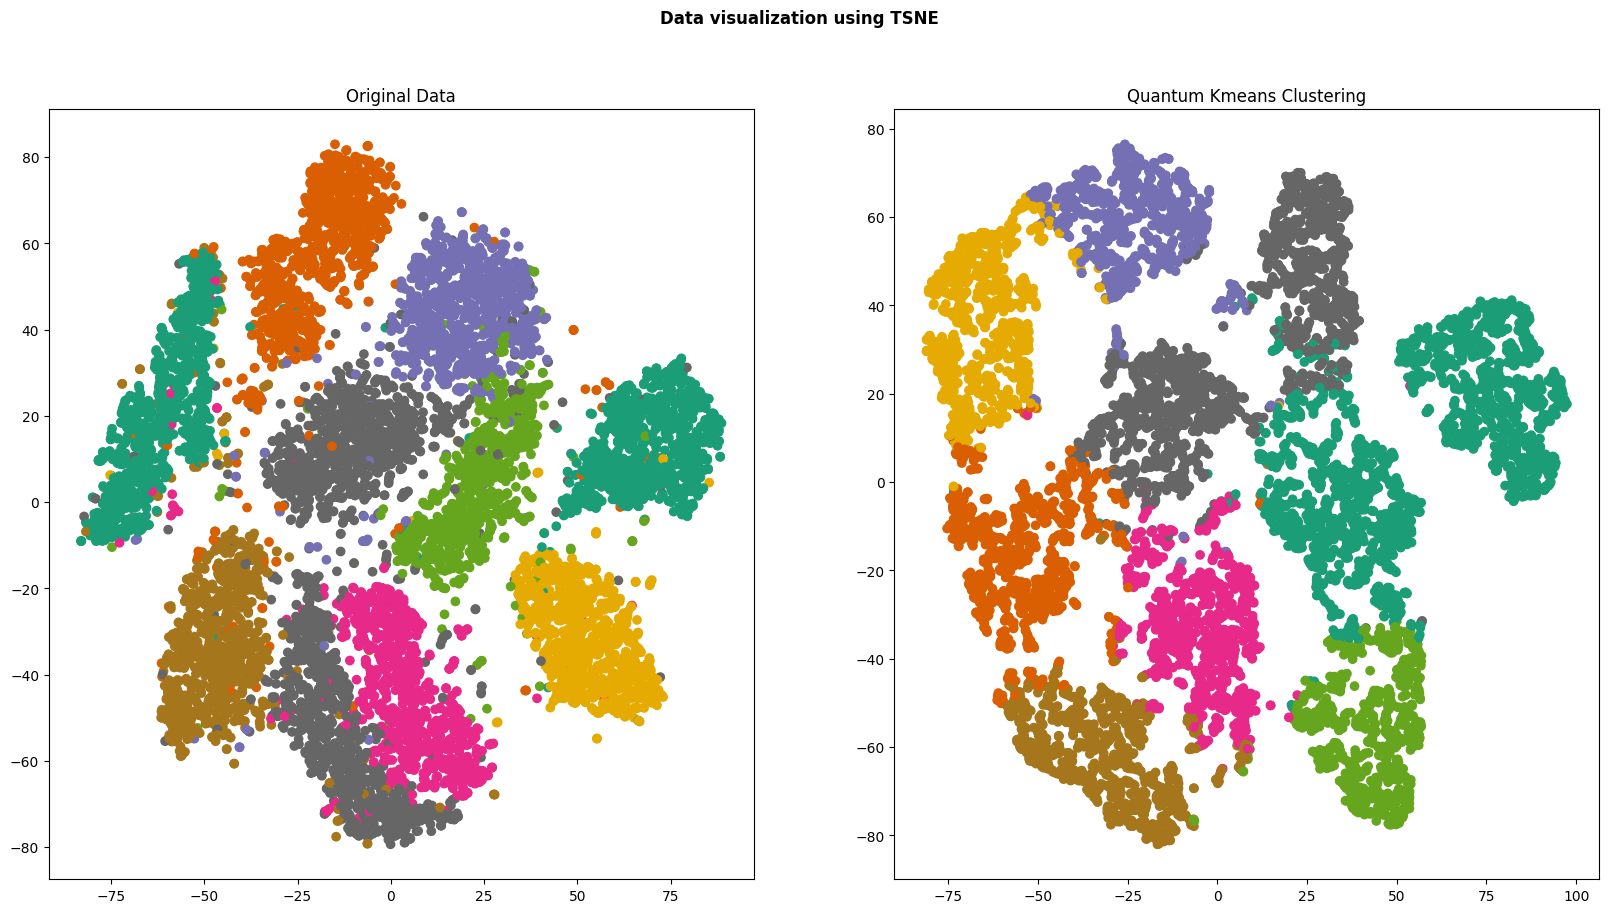

In [106]:
#Visualize the cluserting
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Data visualization using TSNE", weight="bold")
ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target[:len(vis_x)], cmap='Dark2')
ax[0].set_title("Original Data")
ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=quantum_prediction2, cmap='Dark2')
ax[1].set_title("Quantum Kmeans Clustering")
plt.show()
